In [3]:
import pandas as pd

In [18]:

from datasets import load_dataset

dataset = load_dataset("Abirate/english_quotes")



In [19]:
import json
def preprocess_quotes(data):
    cleaned_data = []
    for item in data:
        quote = item.get("quote", "").strip().lower()
        author = item.get("author", "").strip().lower()
        tags = [t.strip().lower() for t in item.get("tags", []) if t.strip()]
        
        if quote and author and tags:
            cleaned_data.append({
                "quote": quote,
                "author": author,
                "tags": tags
            })
    return cleaned_data

# Step 5: Apply preprocessing
cleaned_quotes = preprocess_quotes(dataset['train'])
df_cleaned = pd.DataFrame(cleaned_quotes)


with open("cleaned_quotes.json", "w") as f:
    json.dump(cleaned_quotes, f, indent=2)


print(f"Cleaned samples: {len(cleaned_quotes)}")
df_cleaned.head()


Cleaned samples: 2499


,quote,author,tags
0,“be yourself; everyone else is already taken.”,oscar wilde,"[be-yourself, gilbert-perreira, honesty, inspi..."
1,"“i'm selfish, impatient and a little insecure....",marilyn monroe,"[best, life, love, mistakes, out-of-control, t..."
2,“two things are infinite: the universe and hum...,albert einstein,"[human-nature, humor, infinity, philosophy, sc..."
3,"“so many books, so little time.”",frank zappa,"[books, humor]"
4,“a room without books is like a body without a...,marcus tullius cicero,"[books, simile, soul]"


Number of unique authors: 867
Top 10 authors:
author
cassandra clare,    99
j.k. rowling,       75
john green,         53
roy t. bennett,     46
mark twain          42
albert einstein     35
suzanne collins,    34
nicholas sparks,    32
oscar wilde,        30
oscar wilde         30
Name: count, dtype: int64
Top 10 tags:
[('love', 327), ('inspirational', 319), ('life', 295), ('humor', 254), ('books', 141), ('inspiration', 87), ('reading', 86), ('happiness', 68), ('writing', 67), ('inspirational-quotes', 65)]


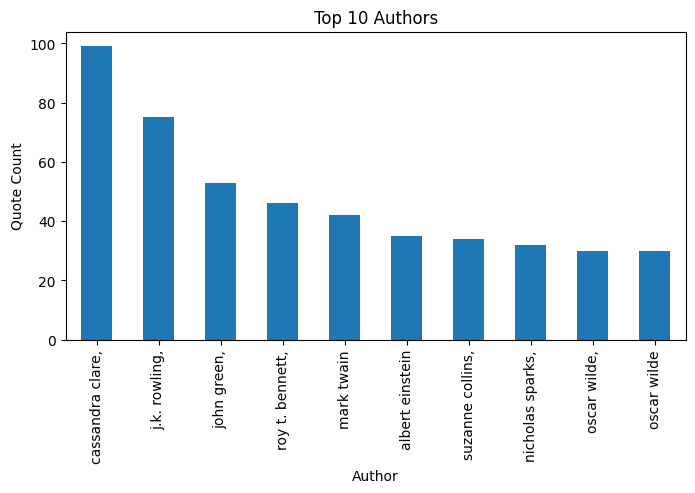

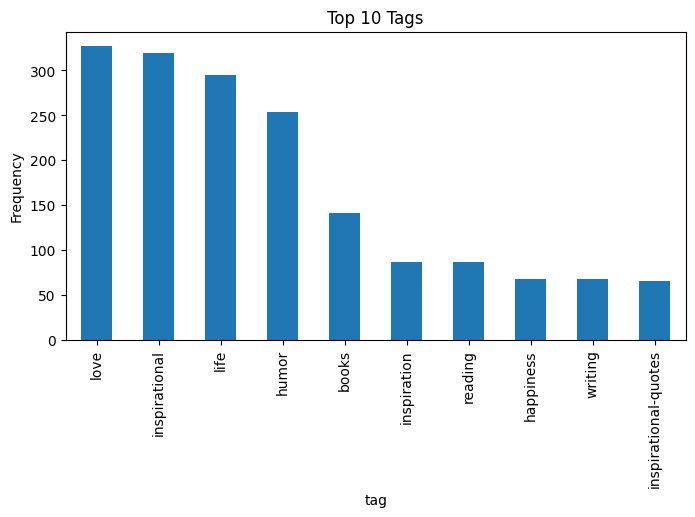

In [5]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

df = pd.DataFrame(cleaned_quotes)

print("Number of unique authors:", df['author'].nunique())
print("Top 10 authors:")
print(df['author'].value_counts().head(10))

all_tags = [tag for sublist in df['tags'] for tag in sublist]
tag_counts = Counter(all_tags).most_common(10)
print("Top 10 tags:")
print(tag_counts)

df['author'].value_counts().head(10).plot(kind='bar', title="Top 10 Authors", figsize=(8, 4))
plt.xlabel("Author")
plt.ylabel("Quote Count")
plt.show()

tags_df = pd.DataFrame(tag_counts, columns=['tag', 'count'])
tags_df.set_index('tag').plot(kind='bar', title="Top 10 Tags", legend=False, figsize=(8, 4))
plt.ylabel("Frequency")
plt.show()


In [6]:
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader
import random

# Load pre-trained model
model = SentenceTransformer('all-MiniLM-L6-v2')

train_examples = []
for item in cleaned_quotes:
    quote = item["quote"]
    author = item["author"]
    tags = item["tags"]


    tag_str = " ".join(tags[:2]) 
    query = f"quotes about {tag_str} by {author}"
    
    train_examples.append(InputExample(texts=[query, quote]))

random.shuffle(train_examples)

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
train_loss = losses.MultipleNegativesRankingLoss(model)


In [ ]:

model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=10,  
    warmup_steps=100,
    show_progress_bar=True
)


model.save("model")


Step,Training Loss
500,0.209300
1000,0.128000
1500,0.087600
2000,0.057500
2500,0.047000
3000,0.036300
3500,0.030300
4000,0.027500
4500,0.021100
5000,0.024200


: 

In [7]:
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np

# Load your fine-tuned model
model = SentenceTransformer("quote-model")

# Create corpus of quotes
corpus = [item["quote"] for item in cleaned_quotes]

# Step 1: Encode all quotes
corpus_embeddings = model.encode(corpus, show_progress_bar=True, convert_to_numpy=True)

# Step 2: Create FAISS index
dimension = corpus_embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(corpus_embeddings)

print(f"FAISS index built with {index.ntotal} quotes.")


Batches: 100%|██████████| 79/79 [00:38<00:00,  2.06it/s]


FAISS index built with 2499 quotes.


In [8]:
def retrieve_quotes(query, top_k=5):
    # Encode user query
    query_embedding = model.encode([query], convert_to_numpy=True)

    # Search in FAISS
    distances, indices = index.search(query_embedding, top_k)

    # Fetch top-k results
    results = []
    for idx in indices[0]:
        result = cleaned_quotes[idx]
        results.append({
            "quote": result["quote"],
            "author": result["author"],
            "tags": result["tags"]
        })
    return results


In [11]:
query = "quotes about love"
results = retrieve_quotes(query)

for r in results:
    print(f"\nQUOTE: {r['quote']}\nAUTHOR: {r['author']}\nTAGS: {r['tags']}")



QUOTE: “it is easy to love people in memory; the hard thing is to love them when they are there in front of you.”
AUTHOR: john updike,
TAGS: ['love']

QUOTE: “love is a fire. but whether it is going to warm your hearth or burn down your house, you can never tell.”
AUTHOR: joan crawford
TAGS: ['love']

QUOTE: “love is like the wind, you can't see it but you can feel it.”
AUTHOR: nicholas sparks,
TAGS: ['love', 'simile']

QUOTE: “love is an untamed force. when we try to control it, it destroys us. when we try to imprison it, it enslaves us. when we try to understand it, it leaves us feeling lost and confused.”
AUTHOR: paulo coelho
TAGS: ['love']

QUOTE: “we loved with a love that was more than love.”
AUTHOR: edgar allen poe
TAGS: ['logic', 'love']


In [20]:
import streamlit as st
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np
import json

# Load fine-tuned model
model = SentenceTransformer("quote-model")

# Load cleaned quotes
import json
with open("cleaned_quotes.json", "r") as f:
    cleaned_quotes = json.load(f)

# Encode and build FAISS index
corpus = [item["quote"] for item in cleaned_quotes]
corpus_embeddings = model.encode(corpus, convert_to_numpy=True, show_progress_bar=True)

dimension = corpus_embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(np.array(corpus_embeddings))

# Query function
def retrieve_quotes(query, top_k=5):
    query_embedding = model.encode([query], convert_to_numpy=True)
    distances, indices = index.search(query_embedding, top_k)

    results = []
    for i, idx in enumerate(indices[0]):
        item = cleaned_quotes[idx]
        results.append({
            "quote": item["quote"],
            "author": item["author"],
            "tags": item["tags"],
            "similarity_score": float(1 / (1 + distances[0][i]))  # simple inverted distance
        })
    return results

# UI
st.title("📚 Semantic Quote Retriever")

query = st.text_input("Enter a natural language query:", placeholder="e.g., quotes about imagination by Einstein")

if query:
    with st.spinner("Searching for matching quotes..."):
        results = retrieve_quotes(query)

        st.subheader("Top Results (JSON View)")
        st.json(results)

        st.subheader("Formatted View")
        for r in results:
            st.markdown(f"""
            **Quote:** _"{r['quote']}"_  
            **Author:** {r['author']}  
            **Tags:** {', '.join(r['tags'])}  
            **Similarity Score:** {r['similarity_score']:.4f}
            ---
            """)


Batches: 100%|██████████| 79/79 [00:39<00:00,  1.99it/s]
2025-07-05 21:55:53.014 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-05 21:55:53.588 
  command:

    streamlit run C:\Users\anshk\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-07-05 21:55:53.593 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-05 21:55:53.599 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-05 21:55:53.603 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-05 21:55:53.608 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-05 21:55:53.615 Thread 'MainThread': missing ScriptRunContext! This warning can be ignore